In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time
import sqlite3

In [4]:
target_csv = "./data/LosAngeles.csv"
csv_losAngeles = pd.read_csv(target_csv,low_memory=False)
target_csv = "./data/AirQualitySystem.csv"
csv_AirQuality = pd.read_csv(target_csv,low_memory=False)

In [102]:
data_url = "https://api.openaq.org/v1/measurements?city=Los Angeles"
data_content = requests.get(data_url)

In [104]:
data_results = data_content.json()
series = {}
series['Los Angeles'] = {}
for data in data_results['results']:
    if data['parameter'] in series['Los Angeles'].keys():
        if data['value'] > 0 :
            series['Los Angeles'][data['parameter']]['value'].append(data['value'])
            timepoint = time.strptime(data['date']['utc'],"%Y-%m-%dT%H:%M:%S.%fZ")
            series['Los Angeles'][data['parameter']]['time'].append(timepoint.tm_yday+timepoint.tm_hour/24)
        else :
            timepoint = time.strptime(data['date']['utc'],"%Y-%m-%dT%H:%M:%S.%fZ")
            timepoint = timepoint.tm_yday+timepoint.tm_hour/24
            if timepoint in series['Los Angeles'][data['parameter']]['error'].keys():
                series['Los Angeles'][data['parameter']]['error'][timepoint] += 1
            else :
                series['Los Angeles'][data['parameter']]['error'][timepoint] = 1
            
    else:
        series['Los Angeles'][data['parameter']] = {}
        series['Los Angeles'][data['parameter']]['value'] = []
        series['Los Angeles'][data['parameter']]['time'] = []
        series['Los Angeles'][data['parameter']]['error'] = {}
        if data['value'] > 0 :
            timepoint = time.strptime(data['date']['utc'],"%Y-%m-%dT%H:%M:%S.%fZ")
            series['Los Angeles'][data['parameter']]['value'].append(data['value'])
            series['Los Angeles'][data['parameter']]['time'].append(timepoint.tm_yday+timepoint.tm_hour/24)
        else :
            timepoint = time.strptime(data['date']['utc'],"%Y-%m-%dT%H:%M:%S.%fZ")
            timepoint = timepoint.tm_yday+timepoint.tm_hour/24
            if timepoint in series['Los Angeles'][data['parameter']]['error'].keys():
                series['Los Angeles'][data['parameter']]['error'][timepoint] += 1
            else :
                series['Los Angeles'][data['parameter']]['error'][timepoint] = 1
            

(array([290.4, 290.6, 290.8, 291. , 291.2, 291.4, 291.6, 291.8, 292. ,
        292.2]), <a list of 10 Text xticklabel objects>)

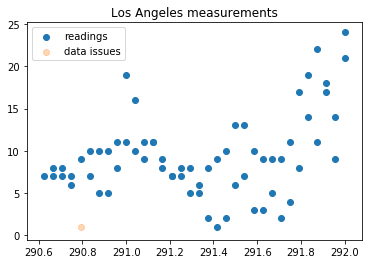

In [109]:
plt.scatter(series['Los Angeles']['pm25']['time'],series['Los Angeles']['pm25']['value'])
plt.scatter(series['Los Angeles']['pm25']['error'].keys(),series['Los Angeles']['pm25']['error'].values(),alpha=.3)
plt.title('Los Angeles measurements')
plt.legend(["readings","data issues"])
plt.xticks()

In [27]:
csv_losAngeles['sourcename'].unique()

array(['AirNow'], dtype=object)

In [6]:
connection = sqlite3.connect('weather-store.db')
cursor = connection.cursor()
#create table co table
creation_table = """CREATE TABLE co_parameter
                    (source text,reading real,unit text,latitude real,longitude real,confidence real,date text)"""
cursor.execute(creation_table)
connection.commit()
connection.close()

In [23]:
#setup database connection
connection = sqlite3.connect('weather-store.db')
cursor = connection.cursor()
#start writing to db
insert_statement = """INSERT INTO co_parameter Values(?,?,?,?,?,?,?)"""
#create value list
count = 0
inserts = []
for index,row in csv_losAngeles.iterrows():
    count += 1
    coords = row['coordinates'].replace("{","").replace("}","")
    coords = coords.split(",")
    location = {'latitude' : float(coords[0].split("=")[1]),'longitude' : float(coords[1].split("=")[1])}
    date = row['date'].replace("{","").replace("}","")
    date = date.split(",")[0].split("=")[1]
    inserts.append([row['sourcename'],row['value'],row['unit'],location['latitude'],location['longitude'],0.0,date])
    if count > 1000:
        cursor.executemany(insert_statement,inserts)
        count = 0
        inserts = []
        

In [46]:
import pymysql
import pymysql.cursors
connection = pymysql.connect(host='35.244.98.157',
                             user='root',
                             password='',
                             db='weatherstore')
try:
    with connection.cursor() as cursor:
        # Create a new record
        insert_statement = """INSERT INTO co_parameter (source,reading,unit,latitude,longitude,confidence,date) Values (%s,%s,%s,%s,%s,%s,%s)"""
        # get rows
        count = 0
        inserts = []
        for index,row in csv_losAngeles.iterrows():
            count += 1
            coords = row['coordinates'].replace("{","").replace("}","")
            coords = coords.split(",")
            location = {'latitude' : float(coords[0].split("=")[1]),'longitude' : float(coords[1].split("=")[1])}
            date = row['date'].replace("{","").replace("}","")
            date = date.split(",")[0].split("=")[1]
            inserts.append([row['sourcename'],row['value'],row['unit'],location['latitude'],location['longitude'],0.0,date])
            if count > 1000:
                cursor.executemany(insert_statement,inserts)
                count = 0
                inserts = []
    connection.commit()

except Excpetion as e: 
    print(e)
    print("oops")
finally:
    connection.close()
        

In [55]:
def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.

    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print ("\t\ttype:", repr(nc_fid.variables[key].dtype))
            for ncattr in nc_fid.variables[key].ncattrs():
                print ('\t\t%s:' % ncattr,
                      repr(nc_fid.variables[key].getncattr(ncattr)))
        except KeyError:
            print ("\t\tWARNING: %s does not contain variable attributes" % key)

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print ("NetCDF Global Attributes:")
        for nc_attr in nc_attrs:
            print ('\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr)))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print("NetCDF dimension information:")
        for dim in nc_dims:
            print ("\tName:", dim)
            print ("\t\tsize:", len(nc_fid.dimensions[dim]))
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print("NetCDF variable information:")
        for var in nc_vars:
            if var not in nc_dims:
                print ('\tName:', var)
                print ("\t\tdimensions:", nc_fid.variables[var].dimensions)
                print ("\t\tsize:", nc_fid.variables[var].size)
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

In [60]:
from netCDF4 import Dataset
nc_file = Dataset(".\data\ecmwf_co2\z_cams_l_lsce_201801_FT18r1_ra_sfc_mm_co2flux.nc")
nc_attrs, nc_dims, nc_vars = ncdump(nc_file)


NetCDF Global Attributes:
	Conventions: 'CF-1.6'
	title: 'Global surface fluxes inferred by atmospheric inversion'
	institution: 'LSCE (CEA/CNRS/UVSQ) - IPSL'
	source: 'Assimilation of XCO2 retrievals'
	history: '2019-06-25 04:39:52 GMT, PYVAR run by fcheval'
	references: 'Chevallier et al. (JGR, 2005, JGR, 2010); Chevallier (GMD, 2013)'
	comment: 'Positive fluxes release carbon to the atmosphere'
NetCDF dimension information:
	Name: longitude
		size: 96
		type: dtype('float64')
		units: 'degrees_east'
		standard_name: 'longitude'
	Name: latitude
		size: 96
		type: dtype('float64')
		units: 'degrees_north'
		standard_name: 'latitude'
NetCDF variable information:
	Name: flux_apri_bio
		dimensions: ('latitude', 'longitude')
		size: 9216
		type: dtype('float64')
		long_name: 'Prior land surface upward mass flux of carbon for the whole grid box and the whole month without fossile'
		units: 'kgC m-2 month-1'
		missing_value: -9999.0
	Name: flux_apri_ocean
		dimensions: ('latitude', 'longitu

In [97]:
nc_file.variables['flux_foss'][6]

masked_array(data=[0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                   0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                   0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                   0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                   0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                   0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                   0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                   0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                   0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                   0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                   0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                   0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                   0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                   0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                   0.00000000e+00, 0.00000000e+00, 0.00000000e

In [24]:
connection.commit()
connection.close()